# COSMO Project
By Mathilde Raynal, Etienne Bonvin and Xavier Pantet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from regressions import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = "data/"
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")
X = np.load(DATA_FOLDER + "pca_x.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

np.random.seed(1)

In [4]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 3004)
y: (30049,)


## Idea 1: Good ol' least squares (MSE loss without regularizer)

We first try a standard and naive implementation of `least_squares` on the full dataset:

In [5]:
def run_least_squares():
    w_star = least_squares(y, X)
    loss = rmse(y, X, w_star)
    print("Loss = " + str(loss))

run_least_squares()

Loss = 26.166553759575127


We see that the loss is quite large! We hope to do better using polynomial expansion using a smaller dataset composed only of a smaller number of features so that we don't need a cluster. We use 4-fold cross-validation to find the best `degree`:

In [6]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_least_squares_poly():
    rmse_tr = []
    rmse_te = []

    for degree in range(4):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, least_squares)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    pd.DataFrame([rmse_tr, rmse_te]).add_prefix("Degree ").rename({0: "Train error", 1: "Test error"}).head()
    return rmse_tr, rmse_te

In [7]:
run_least_squares_poly()

([3.214363737341961,
  0.5956012277327409,
  0.4661340477548795,
  0.3562751890194217],
 [3.214384303727872,
  0.7107496454416272,
  0.7489895213565038,
  1.0423134308771025])

Indeed, polynomial expansion provides better results. Moreover, we see that the best `degree` is 1.

__By adding a single feature of constant values, we manage to decrease the RMSE from 26 to 0.7!__

## Idea 2: Ridge regression (MSE loss with $\mathcal{L}_2$-regulizer)

In [8]:
k_fold = 4
k_indices = build_k_indices(y, k_fold)

def run_ridge_regression():
    for lambda_ in np.logspace(-5, 1, 7):
        print("Lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    Degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
            for k in range(k_fold):
                ridge_lambda = lambda y, X: ridge_regression(y, X, lambda_)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, ridge_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

In [9]:
run_ridge_regression()

Lambda = 1e-05
    Degree = 1
        0.5956012277327412
        0.7107496453242187
    Degree = 2
        0.46613404775498773
        0.7489895167328673
Lambda = 0.0001
    Degree = 1
        0.5956012277327529
        0.7107496442675574
    Degree = 2
        0.46613404776569345
        0.7489894751442037
Lambda = 0.001
    Degree = 1
        0.595601227733922
        0.7107496337022221
    Degree = 2
        0.46613404883618903
        0.7489890616490246
Lambda = 0.01
    Degree = 1
        0.5956012278508356
        0.7107495281758753
    Degree = 2
        0.46613415581978157
        0.7489851656593154
Lambda = 0.1
    Degree = 1
        0.5956012395420908
        0.7107484856140888
    Degree = 2
        0.4661447884335308
        0.748969941829664
Lambda = 1.0
    Degree = 1
        0.5956024085635065
        0.7107393300294402
    Degree = 2
        0.4671445127958839
        0.751035239705691
Lambda = 10.0
    Degree = 1
        0.5957191962706814
        0.7107746313203024
  

We see that the best test error is achieved with a regulizer of $\lambda = 10^{-5}$ for `degree 1` and $\lambda = 10^{-2}$ for `degree 2`. In all cases, `degree 1` remains our best degree value.

Since the results are almost equal with and without a regulizer and provided that the test error increases for larger values of $\lambda$, we deduce that the model is not overfitted and that a $\mathcal{L}_2$ regulizer is useless...

## Idea 3: Lasso (MSE loss with $\mathcal{L}_1$-regulizer)

In [10]:
X = build_poly(X, 1)
def run_lasso():
    for lambda_ in np.concatenate([[0], np.logspace(-5, 2, 8)]):
        print("lambda = " + str(lambda_))
        for degree in range(1, 3):
            print("    degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
    
            for k in range(k_fold):
                lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
                lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
                loss_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 500, 1e-2, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, loss_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("        " + str(np.mean(rmse_tr_tmp)))
            print("        " + str(np.mean(rmse_te_tmp)))

Before we run it, we try a `stochastic_gradient_descent` using a `lasso`, just to see what we can expect:

In [11]:
lambda_ = 0
lasso_lambda = lambda y, X, w: lasso(y, X, w, lambda_)
lasso_stoch_grad_lambda = lambda y, X, w: lasso_stoch_grad(y, X, w, lambda_)
_, losses = stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 500, 1e-2, lasso_lambda, lasso_stoch_grad_lambda, batch_size = 100, detail = True)

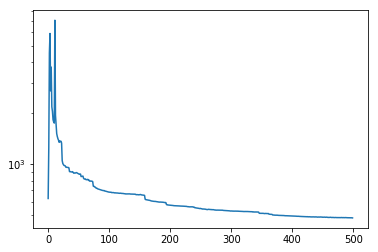

In [12]:
plt.semilogy(losses)

In [13]:
print(np.argmin(losses))
print(losses[np.argmin(losses)])

499
481.6724402132188


Looking at the result, it is unlikely to do better than `ridge_regression`, therefore we drop this idea.

## Idea 4: MAE loss (with SGD)

In [14]:
def run_mae_sgd():
    for _ in [0]:
        for degree in range(1, 3):
            print("degree = " + str(degree))
            rmse_tr_tmp = []
            rmse_te_tmp = []
    
            for k in range(k_fold):
                mae_lambda = lambda y, X: stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 50, 1e-3, mae, mae_stoch_grad, batch_size = 100)
                loss_tr, loss_te, _ = cross_validation(y, X, k_indices, k, degree, mae_lambda)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            print("    " + str(np.mean(rmse_tr_tmp)))
            print("    " + str(np.mean(rmse_te_tmp)))

Again, we first try to validate the method before we run that.

In [15]:
ws, losses = stochastic_gradient_descent(y, X, np.zeros(X.shape[1]), 100, 1, mae, mae_stoch_grad, batch_size = 100, detail = True)

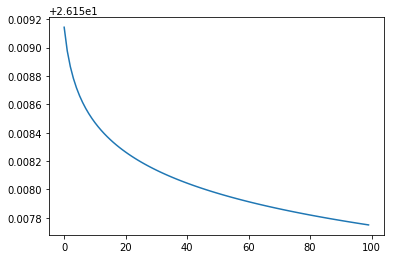

In [16]:
plt.plot(losses)

In [17]:
print(np.argmin(losses))
print(losses[np.argmin(losses)])

99
26.157749940133527


In [18]:
ws

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 3.32778702e-04, -3.12426855e-04,  3.46571600e-04, ...,
         4.71631495e-06,  3.54825899e-05,  2.44883581e-05]),
 array([ 4.99168053e-04, -4.43372405e-04,  4.84418451e-04, ...,
        -1.98760894e-06,  3.86820796e-05,  2.48805948e-05]),
 array([ 6.10094287e-04,  2.12192166e-04,  6.95675019e-04, ...,
        -4.23382064e-06,  4.34382335e-05,  2.57710107e-05]),
 array([ 6.93288963e-04, -5.85134289e-06,  6.00068422e-04, ...,
        -7.82824972e-07,  4.33136598e-05,  2.53521864e-05]),
 array([ 7.59844703e-04,  1.60025958e-04,  3.46875812e-04, ...,
        -1.81111100e-06,  4.74224718e-05,  3.17038043e-05]),
 array([ 8.15307820e-04,  2.51787898e-04,  4.11749256e-04, ...,
        -2.85201279e-06,  4.19414997e-05,  2.87412222e-05]),
 array([ 8.62847635e-04,  1.93026555e-04,  3.17010139e-04, ...,
        -3.08744120e-06,  4.14895384e-05,  3.17743229e-05]),
 array([ 9.04444973e-04, -7.60401041e-06,  3.66601992e-04, ...,
        -4.38968287e-0

Well, it seems that the loss does not change, leading to a non convergence of the method even if `ws` is changing... We don't expect to do better either...